# Gaussian Fit Demonstration

This notebook shows how to perform spectral deconvolution using the FTIR tool suite developed by KBI Biopharma. 

The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra using a guassian peak model. Gradiant based solvers can be utilized using the `gaussian_miminize`. The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. A stochastic method, `gaussian_differential_evolution`, can be used to try to attempt to find the global minimum within the defined parameters space, however this may take a very long time, and may not completely converge.

In [1]:
# imports
%matplotlib inline
import os
import pandas as pd
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list
from ftir.modeling.peak_definitions import yang_h20_2015
from ftir.io.utils import create_df_from_single_file
from ftir.io.file_importer import file_select, file_upload, graphical_VM_file_importer
from ftir.io.select_traces import multi_checkbox_grapher


### Import from a local file (zipped data folder or MS Excel file) filesize limit ~15MB

In [2]:
ftir_file = file_select()

FileUpload(value={}, accept='.csv, .xlsx, xls', description='Upload')

In [3]:
file_upload(ftir_file) 

csv file imported


In [4]:
test = graphical_VM_file_importer()  #creates an object called "test"

Output()

In [7]:
df, sample_names, metadata = test.df, test.sample_names, test.metadata

In [8]:
select_files = multi_checkbox_grapher(sample_names, df)

Output()

## Fitting using least squares solver
Suggested method based on literature 

Why do we use a least square solver?

In [15]:
rawData_df = df[select_files].copy()

In [16]:
select_files

['freq',
 'PDB: 2lyz; Lysozyme (chicken egg)_deriv_baselineCorr',
 'PDB: 2ZFG; porin _deriv_baselineCorr']

In [17]:
i = 1 # set the i value to the sample you want analyzed
sample = select_files[i]

Analyzing PDB: 2lyz; Lysozyme (chicken egg)_deriv_baselineCorr


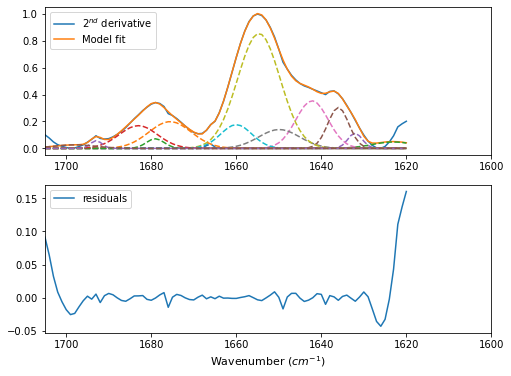

In [18]:
print("Analyzing {}".format(sample))
area, res = gaussian_least_squares(rawData_df, sample, peaks=yang_h20_2015, params={'loss':'linear'})
gaussian_list_data = gaussian_list(rawData_df['freq'], *res.x)
plt = create_fit_plots(rawData_df, sample, gaussian_list_data)
plt.savefig('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.png', dpi=600)
plt.show()

In [19]:
structs = secondary_structure(area, yang_h20_2015)
structs_df = pd.DataFrame(list(structs.items()), columns=['Structure','Fraction'])
structs_df.to_csv('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.csv', index=False)
structs_df

,Structure,Fraction
0,unordered,0.065789
1,β-sheet,0.266359
2,β-turn,0.188264
3,α-helix,0.416901
4,310-helix,0.062688


## Fitting Gaussian Peaks using Gradient Solvers
Gradient based solvers will converge relatively quickly. Only bounded solvers are permitted to improve the stability of the solution. These solvers are:
* L-BFGS-B: Limited-memory Broyden–Fletcher–Goldfarb–Shanno solver
* TNC: Truncated Newton methods
* SLSQP: SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver.
* trust-constr: Trust-Region Constrained Algorithm 

I have not yet evaluated the best solver for this particular problem.

In [ ]:
area, res = gaussian_minimize(rawData_df, sample, params={'method': 'trust-constr'})
gaussian_list_data = gaussian_list(rawData_df['freq'], *res.x)
plt = create_fit_plots(current_df, sample, gaussian_list_data)
# plt.savefig('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.png', dpi=600)
plt.show()

In [ ]:
structs = secondary_structure(area, yang_h20_2015)
structs_df = pd.DataFrame(list(structs.items()), columns=['Structure','Fraction'])
# structs_df.to_csv('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.csv', index=False)
structs_df

## Comparison of different gradient solvers

Discuss what that advantages of each are...


In [ ]:
bfgs, res = gaussian_minimize(current_df, current_df.columns[index], params={'method': 'L-BFGS-B'})
tnc, res = gaussian_minimize(current_df, current_df.columns[index], params={'method': 'TNC'})
slsqp, res = gaussian_minimize(current_df, current_df.columns[index], params={'method': 'SLSQP'})
# tc, res = gaussian_minimize(current_df, current_df.columns[index], params={'method': 'trust-constr'})

bfgs_structs = secondary_structure(bfgs, yang_h20_2015)
tnc_structs = secondary_structure(tnc, yang_h20_2015)
slsqp_structs = secondary_structure(slsqp, yang_h20_2015)
# tc_structs = secondary_structure(tc, yang_h20_2015)

print(bfgs_structs)
print(tnc_structs)
print(slsqp_structs)

## Differential evolutionary solver

In [ ]:
params={'maxiter': 1000}  # default is 1000. Takes a very long time!
area, res = gaussian_differential_evolution(current_df, current_df.columns[index], params=params)
gaussian_list_data = gaussian_list(rawData_df['freq'], *res.x)
plt = create_fit_plots(current_df, sample, gaussian_list_data)
# plt.savefig('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.png', dpi=600)
plt.show()

In [ ]:
print('{0} Number of iterations: {1}'.format(res.message, res.nit))

In [ ]:
structs = secondary_structure(area, yang_h20_2015)
structs_df = pd.DataFrame(list(structs.items()), columns=['Structure','Fraction'])
# structs_df.to_csv('/home/jovyan/ftir_data_analytics/data/fitted_results/'+sample+'.csv', index=False)
structs_df